# Welcome to Computer Vision! #

Have you ever wanted to teach a computer to see? In today's class, that's exactly what we'll do!

You will:
- Use modern deep-learning networks to build an **image classifier** with Keras
- Master the art of **transfer learning** to boost your models
- Learn the fundamental ideas behind visual **feature extraction**: Filter, Detect, Condense

In lecture and lab, we're going to be creating image classifiers that attempt to solve the following problem: is this a picture of a package *with a label* or of *without a label*? Our dataset is about 2,000 pictures of various packages, around half with label and half without a label.

Now let's get started!

## Setting Up the Workspace

In [1]:
# Imports
import pandas as pd
import numpy as np
from itertools import product

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
#from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow import keras
from tensorflow.keras import layers

# Reproducability
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [2]:
def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

## Loading the Data

This next few cells will set up our data pipeline. We have a training set called `ds_train` and a validation set called `ds_valid`.

In [3]:
!wget -O data.zip https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
!unzip -o data.zip

--2023-04-23 15:39:34--  https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip [following]
--2023-04-23 15:39:34--  https://www.dropbox.com/s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc07f8b920c5ca5f8f76bb52e101.dl.dropboxusercontent.com/cd/0/get/B6tyroHsbQmk2ZXKtVhEzq68cPfOAW_fQyMIW_L0qwZK3fHuv-Guy-mlvrv_8nqGcCc8OE_FfLF1-QnLNsGlWfE4_a-fVSHMIforfJPBMFdHYiaGn9V_xJqznstMQJrk3yfnDvk9PWJ5IeI0ZVNweI1XTF0zD1C0C-C-NKrK033ZVBHa3twXvhamH7ImC4iT9Io/file?dl=1# [following]
--2023-04-23 15:39:35--  https://uc07f8b920

In [4]:
# Define the input function
def read_tf_records(tfrecord_path, batch_size):
    # Create a TFRecordDataset object
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Define the feature description
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
    }


    # Parse the record into tensors
    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    # Apply the parse function to every record
    dataset = dataset.map(_parse_function)
    # Decode the image
    def decode_image(record):
        image = tf.image.decode_jpeg(record['image/encoded'], channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (224, 224))
        image = tf.reshape(image, [-1, 224, 224, 3])
        label = tf.sparse.to_dense(record['image/object/class/label'])
        #Convert label into binary classification whether the box has a label
        label = tf.maximum(0, tf.reduce_max(tf.cast(tf.math.equal(label, 1), tf.int32)))
        label = tf.reshape(label, (-1,1))
        return image, label

    # Apply the decode_image function to every record
    dataset = dataset.map(decode_image)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Return the dataset
    return dataset

ds_train = read_tf_records('train/Package-and-label.tfrecord',256)
ds_valid = read_tf_records('valid/Package-and-label.tfrecord',256)
ds_test = read_tf_records('test/Package-and-label.tfrecord',256)

Let's take a look at a few examples from the training set.

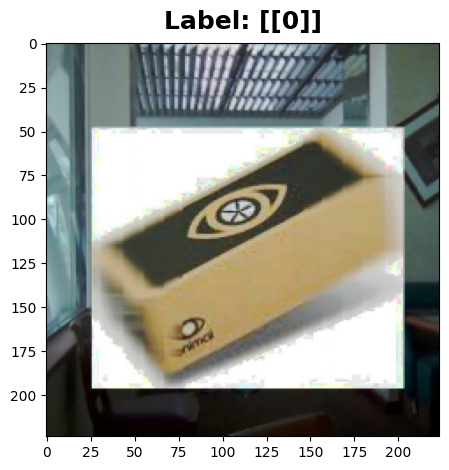

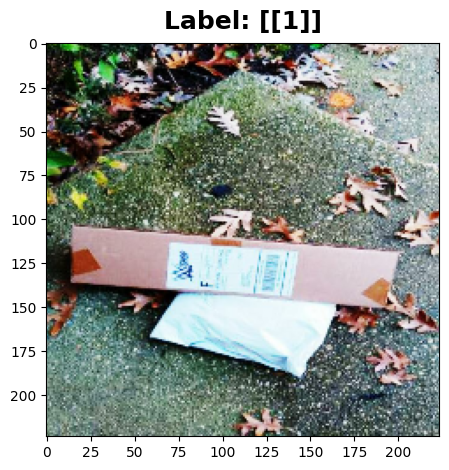

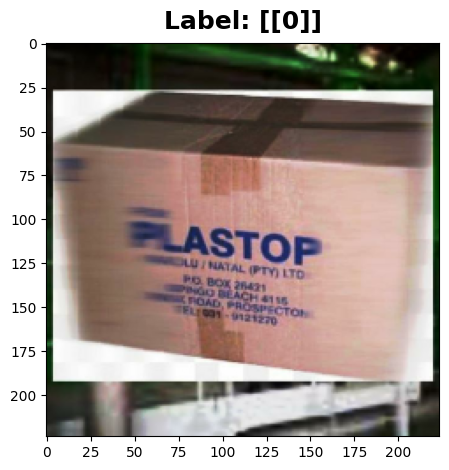

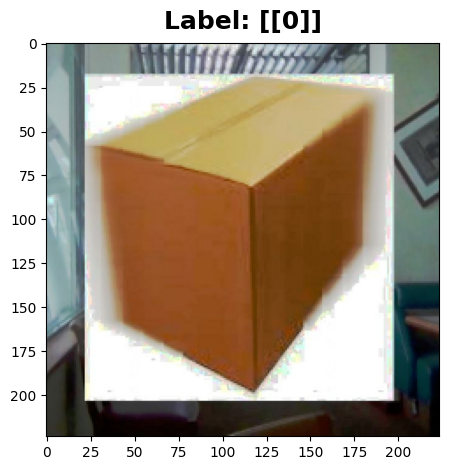

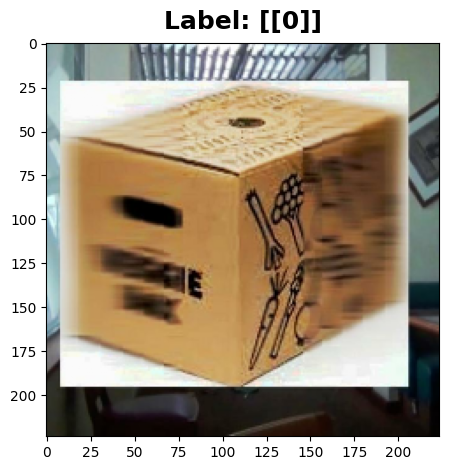

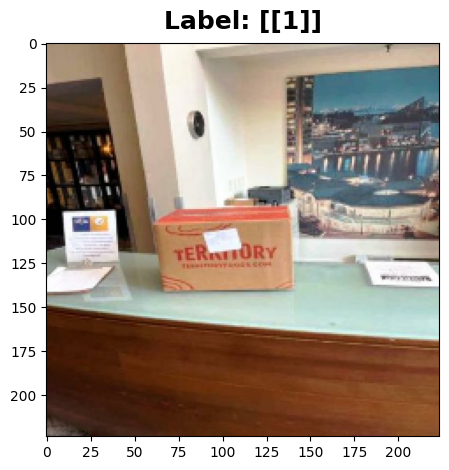

In [5]:
ds_iter = iter(ds_test)
image, label = next(ds_iter)

# Plot the image
plt.imshow(image.numpy()[0])
plt.title(f"Label: {label}")
plt.show()

for i in range(5):
  image, label = next(ds_iter)

  # Plot the image
  plt.imshow(image.numpy()[0])
  plt.title(f"Label: {label}")
  plt.show()

---
# 1. Image Classification

This notebook will introduce you to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say **convnet** or **CNN** instead.) Convolution is the mathematical operation that gives the layers of a ConvNet their unique structure. Later, you'll learn why this structure is so effective at solving computer vision problems.

We will apply these ideas to the problem of **image classification**: given a picture, can we train a computer to tell us what it's a picture *of*? You will learn how to build image classifiers just as powerful as those used in professional applications.

While our focus will be on image classification, what you'll learn in this course is relevant to every kind of computer vision problem. At the end, you'll be ready to move on to more advanced applications like generative adversarial networks.

## The Convolutional Classifier

A convnet used for image classification consists of two parts: a **base** and a **head**.

<center>
<!-- <img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">-->
<img src="https://i.ibb.co/NKPMsyW/boxwlabel.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">
</center>

The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but includes other kinds of layers as well. 

The head is used to **determine the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.


## Training the Classifier

The goal of the network during training is to learn two things:
1. which features to extract from an image (base),
2. which class goes with what features (head).

## Transfer Learning

These days, convnets are rarely trained from scratch. More often, we **reuse the base of a pretrained model**. To the pretrained base we then **attach an untrained head**. In other words, we reuse the part of a network that has already learned to do *1. Extract features*, and attach to it some fresh layers to learn *2. Classify*.

<center>
<!-- <img src="./images/1-attach-head-to-base.png" width="400" alt="Attaching a new head to a trained base."> -->
<img src="https://imgur.com/E49fsmV.png" width="400" alt="Attaching a new head to a trained base.">
</center>

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data. 

Reusing a pretrained model is a technique known as **transfer learning**. It is so effective, that almost every image classifier these days will make use of it.

## Example - Train a Convnet Classifier using Transfer Learning



Let's take a look at a few examples from the training set.

### Step 1 - Define Pretrained Base 

The most commonly used dataset for pretraining is [*ImageNet*](http://image-net.org/about-overview), a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its [`applications` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications). The pretrained model we'll use is called **VGG16**.

In [6]:
pretrained_base = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
pretrained_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


### Step 2 - Attach Head

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first `Dense` layer) followed by a layer to transform the outputs to a probability score for class 1, `with label`. The `Flatten` layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [7]:
model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'), 
    layers.Dense(1, activation='sigmoid'),
])

### Step 3 - Train

Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of `crossentropy` and `accuracy`. The `adam` optimizer generally performs well, so we'll choose it as well.

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)


history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/50
1635/1635 [==============================] - 34s 11ms/step - loss: 0.7189 - binary_accuracy: 0.5187 - val_loss: 0.6942 - val_binary_accuracy: 0.4901
Epoch 2/50
1635/1635 [==============================] - 18s 11ms/step - loss: 0.6929 - binary_accuracy: 0.5156 - val_loss: 0.6945 - val_binary_accuracy: 0.4901
Epoch 3/50
1635/1635 [==============================] - 19s 11ms/step - loss: 0.6929 - binary_accuracy: 0.5156 - val_loss: 0.6947 - val_binary_accuracy: 0.4901
Epoch 4/50
1635/1635 [==============================] - 20s 12ms/step - loss: 0.6929 - binary_accuracy: 0.5156 - val_loss: 0.6948 - val_binary_accuracy: 0.4901
Epoch 5/50
1635/1635 [==============================] - 17s 10ms/step - loss: 0.6929 - binary_accuracy: 0.5156 - val_loss: 0.6948 - val_binary_accuracy: 0.4901
Epoch 6/50
1635/1635 [==============================] - 17s 11ms/step - loss: 0.6929 - binary_accuracy: 0.5156 - val_loss: 0.6949 - val_binary_accuracy: 0.4901
Epoch 7/50
1635/1635 [==================

When training a neural network, it's always a good idea to examine the loss and metric plots. The `history` object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

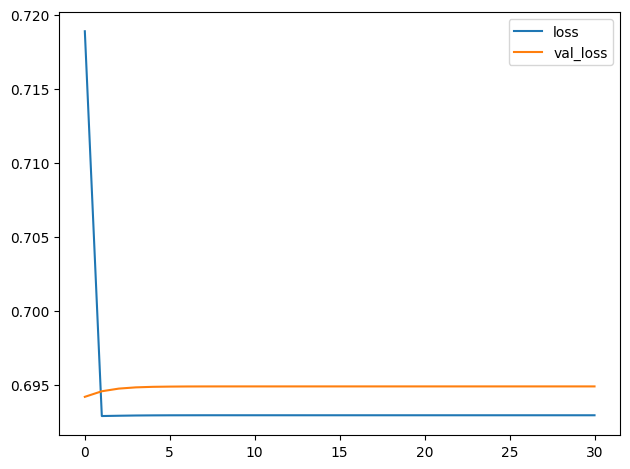

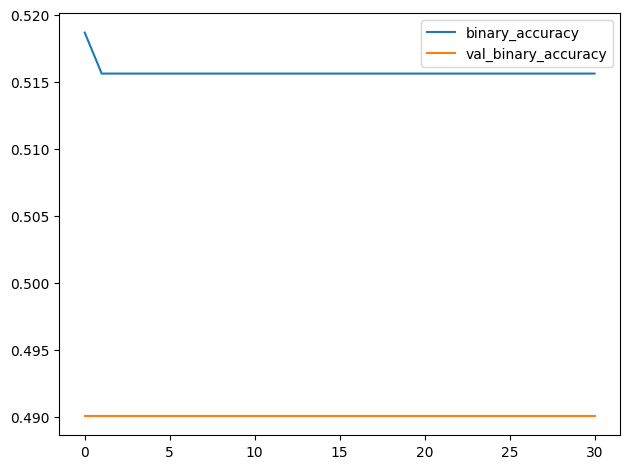

In [9]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

We showed you the structure of a convnet classifier: a **head** to act as a classifier atop of a **base** which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about at the end of last class. For features, it uses those features extracted by the base. This is the basic idea behind convolutional classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

Later we'll take a look at how the convolutional base accomplishes the feature extraction. Then, you'll learn how to apply these ideas and design some classifiers of your own.

---
# 2. Feature Extraction

We saw that a convolutional classifier has two parts: a convolutional **base** and a **head** of dense layers. We learned that the job of the base is to extract visual features from an image, which the head would then use to classify the image.

We're going to learn about the two most important types of layers that you'll usually find in the base of a convolutional image classifier. These are:

1.   the **convolutional layer** with **ReLU activation**, and
2.   the **maximum pooling layer**

Next week, you'll learn how to design your own convnet by composing these layers into blocks that perform the feature extraction.

First we will tell you about the convolutional layer with its ReLU activation function.

Before we get into the details of convolution, let's discuss the *purpose* of these layers in the network. We're going to see how these three operations (convolution, ReLU, and maximum pooling) are used to implement the feature extraction process.

The **feature extraction** performed by the base consists of **three basic operations**:
1. **Filter** an image for a particular feature (convolution)
2. **Detect** that feature within the filtered image (ReLU)
3. **Condense** the image to enhance the features (maximum pooling)

The next figure illustrates this process. You can see how these three operations are able to isolate some particular characteristic of the original image (in this case, horizontal lines).

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://i.ibb.co/jvSm5fn/feature-extraction.png" width="600" alt="An example of the feature extraction process.">
<figcaption style="textalign: center; font-style: italic"><center>The three steps of feature extraction.</center></figcaption>
</figure>

Typically, the network will perform several extractions in parallel on a single image. In modern convnets, it's not uncommon for the final layer in the base to be producing over 1000 unique visual features.


## Filter with Convolution

A convolutional layer carries out the filtering step. You might define a convolutional layer in a Keras model something like this:

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

We can understand these parameters by looking at their relationship to the *weights* and *activations* of the layer. Let's do that now.

## Weights ##

The **weights** a convnet learns during training are primarily contained in its convolutional layers. These weights we call **kernels**. We can represent them as small arrays:

<figure>
<!-- <img src="./images/3-kernel.png" width="150" alt="A 3x3 kernel."> -->
<img src="https://i.imgur.com/uJfD9r9.png" width="150" alt="A 3x3 kernel.">
</figure>

A kernel operates by scanning over an image and producing a *weighted sum* of pixel values. In this way, a kernel will act sort of like a polarized lens, emphasizing or deemphasizing certain patterns of information.

<figure>
<!-- <img src="./images/3-kernel-lens.png" width="400" alt="A kernel acts as a kind of lens."> -->
<img src="https://i.imgur.com/j3lk26U.png" width="250" alt="A kernel acts as a kind of lens.">
<figcaption style="textalign: center; font-style: italic"><center>A kernel acts as a kind of lens.</center></figcaption>
</figure>

Kernels define how a convolutional layer is connected to the layer that follows. The kernel above will connect each neuron in the output to nine neurons in the input. By setting the dimensions of the kernels with `kernel_size`, you are telling the convnet how to form these connections. Most often, a kernel will have odd-numbered dimensions -- like `kernel_size=(3, 3)` or `(5, 5)` -- so that a single pixel sits at the center, but this is not a requirement.

The kernels in a convolutional layer determine what kinds of features it creates. During training, a convnet tries to learn what features it needs to solve the classification problem. This means finding the best values for its kernels.


## Activations ##

The **activations** in the network we call **feature maps**. They are what result when we apply a filter to an image; they contain the visual features the kernel extracts. Here are a few kernels pictured with feature maps they produced.

<figure>
<img src="https://i.ibb.co/5rZCGRb/kernels-example.png" width="800" alt="Three kernels and the feature maps they produce."><figcaption style="textalign: center; font-style: italic"><center>Kernels and features.</center></figcaption>
</figure>

From the pattern of numbers in the kernel, you can tell the kinds of feature maps it creates. Generally, what a convolution accentuates in its inputs will match the shape of the *positive* numbers in the kernel. The left and middle kernels above will both filter for horizontal shapes.

With the `filters` parameter, you tell the convolutional layer how many feature maps you want it to create as output.


## Detect with ReLU #

After filtering, the feature maps pass through the activation function. The **rectifier function** has a graph like this:

<figure>
<!-- <img src="./images/relu.png" width="300" alt=""> -->
<img src="https://i.imgur.com/DxGJuTH.png" width="300" alt="Graph of the ReLU activation function.">
<figcaption style="textalign: center; font-style: italic"><center>The graph of the rectifier function looks like a line with the negative part "rectified" to 0.</center></figcaption>
</figure>

A neuron with a rectifier attached is called a *rectified linear unit*. For that reason, we might also call the rectifier function the **ReLU activation** or even the ReLU function.

The ReLU activation can be defined in its own `Activation` layer, but most often you'll just include it as the activation function of `Conv2D`.

In [11]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

You could think about the activation function as scoring pixel values according to some measure of importance. The ReLU activation says that negative values are not important and so sets them to 0. ("Everything unimportant is equally unimportant.")

Here is ReLU applied the feature maps above. Notice how it succeeds at isolating the features.

<figure>
<!-- <img src="./images/3-relu-and-maps.png" width="800" alt="ReLU applied to feature maps."> -->
<img src="https://i.imgur.com/C4ypq0x.png" width="800" alt="ReLU applied to feature maps.">
</figure>

Like other activation functions, the ReLU function is **nonlinear**. Essentially this means that the total effect of all the layers in the network becomes different than what you would get by just adding the effects together -- which would be the same as what you could achieve with only a single layer. The nonlinearity ensures features will combine in interesting ways as they move deeper into the network. (We'll explore this "feature compounding" more later)



## Example - Apply Convolution and ReLU

We'll do the extraction ourselves in this example to understand better what convolutional networks are doing "behind the scenes".

Here is the image we'll use for this example:

In [12]:
!curl https://i.imgur.com/GvRI0Td.jpg > box_photo.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125k  100  125k    0     0  1235k      0 --:--:-- --:--:-- --:--:-- 1235k


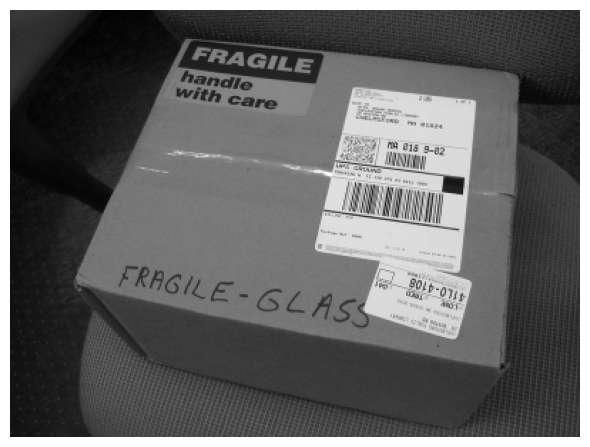

In [13]:

import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = 'box_photo.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[300, 400])

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

For the filtering step, we'll define a kernel and then apply it with the convolution. The kernel in this case is an "edge detection" kernel. You can define it with `tf.constant` just like you'd define an array in Numpy with `np.array`. This creates a *tensor* of the sort TensorFlow uses.

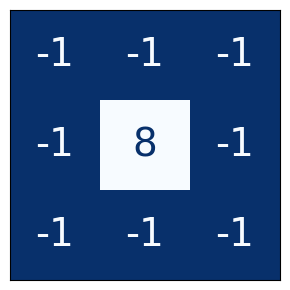

In [14]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

TensorFlow includes many common operations performed by neural networks in its `tf.nn` [module](https://www.tensorflow.org/api_docs/python/tf/nn). The two that we'll use are `conv2d` and `relu`. These are simply function versions of Keras layers.

This next cell does some reformatting to make things compatible with TensorFlow. The details aren't important for this example.

In [15]:

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

Now let's apply our kernel and see what happens.

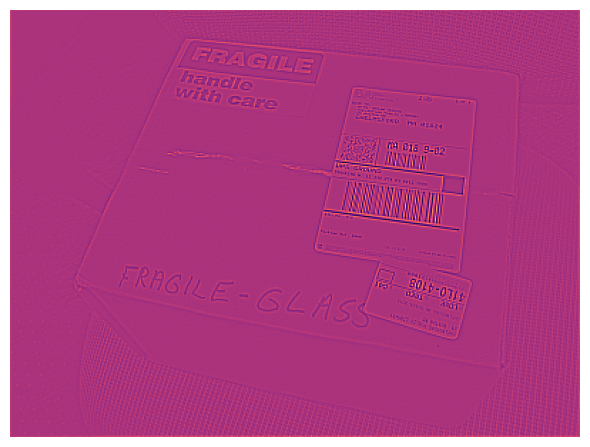

In [16]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two later
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

Next is the detection step with the ReLU function. This function is much simpler than the convolution, as it doesn't have any parameters to set.

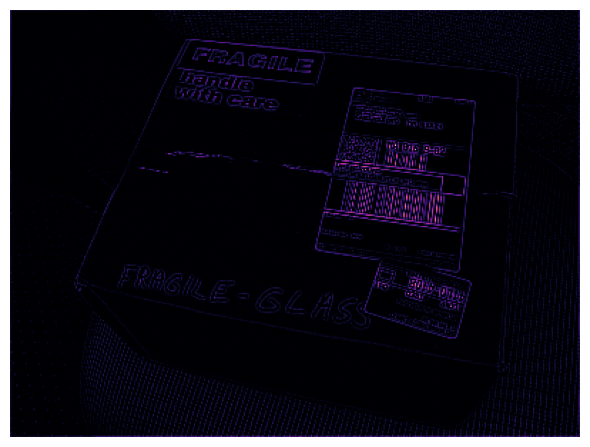

In [17]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

And now we've created a feature map! Images like these are what the head uses to solve its classification problem. We can imagine that certain features might be more characteristic of *Cars* and others more characteristic of *Trucks*. The task of a convnet during training is to create kernels that can find those features.

## Condense with Maximum Pooling #

We began our discussion of how the base in a convnet performs feature extraction. We learned about how the first two operations in this process occur in a `Conv2D` layer with `relu` activation.

Now, we'll look at the third (and final) operation in this sequence: **condense** with **maximum pooling**, which in Keras is done by a `MaxPool2D` layer.

Adding condensing step to the model we had before, will give us this:

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

A `MaxPool2D` layer is much like a `Conv2D` layer, except that it uses a simple maximum function instead of a kernel, with the `pool_size` parameter analogous to `kernel_size`. A `MaxPool2D` layer doesn't have any trainable weights like a convolutional layer does in its kernel, however.

Let's take another look at the extraction figure from before. Remember that `MaxPool2D` is the **Condense** step.

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://i.ibb.co/jvSm5fn/feature-extraction.png" width="600" alt="An example of the feature extraction process.">
</figure>

Notice that after applying the ReLU function (**Detect**) the feature map ends up with a lot of "dead space," that is, large areas containing only 0's (the black areas in the image). Having to carry these 0 activations through the entire network would increase the size of the model without adding much useful information. Instead, we would like to *condense* the feature map to retain only the most useful part -- the feature itself.

This in fact is what **maximum pooling** does. Max pooling takes a patch of activations in the original feature map and replaces them with the maximum activation in that patch.

<figure>
<!-- <img src="./images/3-max-pooling.png" width="600" alt="Maximum pooling replaces a patch with the maximum value in that patch."> -->
<img src="https://imgur.com/hK5U2cd.png" width="400" alt="Maximum pooling replaces a patch with the maximum value in that patch.">
</figure>

When applied after the ReLU activation, it has the effect of "intensifying" features. The pooling step increases the proportion of active pixels to zero pixels.



## Example - Apply Maximum Pooling 

Let's add the "condense" step to the feature extraction we did in the example before.

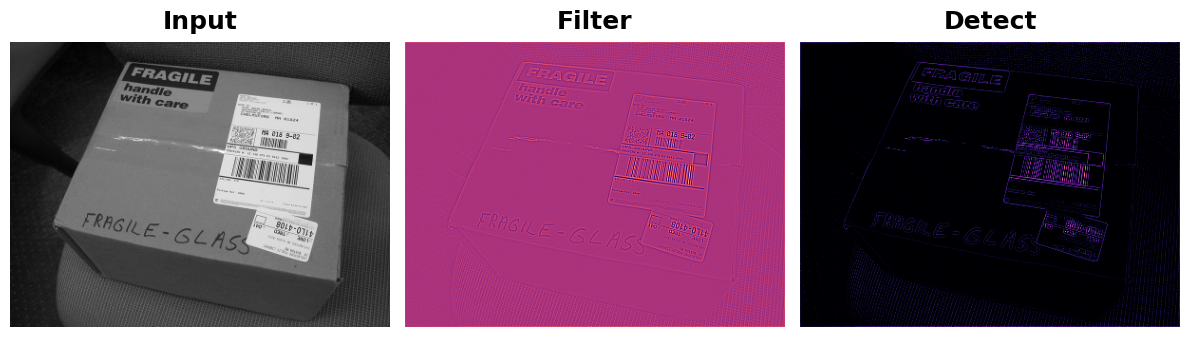

In [20]:

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Read image
image_path = 'box_photo.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[300, 400])

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two soon!
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

We'll use another one of the functions in `tf.nn` to apply the pooling step, `tf.nn.pool`. This is a Python function that does the same thing as the `MaxPool2D` layer you use when model building, but, being a simple function, is easier to use directly.

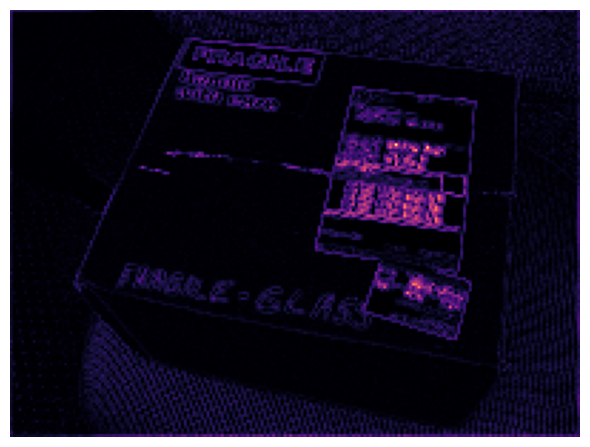

In [ ]:

image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do later on!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

Pretty cool! Hopefully you can see how the pooling step was able to intensify the feature by condensing the image around the most active pixels.

## Translation Invariance #

We called the zero-pixels "unimportant". Does this mean they carry no information at all? In fact, the zero-pixels carry *positional information*. The blank space still positions the feature within the image. When `MaxPool2D` removes some of these pixels, it removes some of the positional information in the feature map. This gives a convnet a property called **translation invariance**. This means that a convnet with maximum pooling will tend not to distinguish features by their *location* in the image. ("Translation" is the mathematical word for changing the position of something without rotating it or changing its shape or size.)

Watch what happens when we repeatedly apply maximum pooling to the following feature map.

<figure>
<!-- <img src="./images/4-two-dots.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://i.imgur.com/97j8WA1.png" width="800" alt="Pooling tends to destroy positional information.">
</figure>

The two dots in the original image became indistinguishable after repeated pooling. In other words, pooling destroyed some of their positional information. Since the network can no longer distinguish between them in the feature maps, it can't distinguish them in the original image either: it has become *invariant* to that difference in position.

In fact, pooling only creates translation invariance in a network *over small distances*, as with the two dots in the image. Features that begin far apart will remain distinct after pooling; only *some* of the positional information was lost, but not all of it.

<figure>
<!-- <img src="./images/4-two-dots-2.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://i.imgur.com/kUMWdcP.png" width="800" alt="But only over small distances. Two dots far apart stay separated">
</figure>

This invariance to small differences in the positions of features is a nice property for an image classifier to have. Just because of differences in perspective or framing, the same kind of feature might be positioned in various parts of the original image, but we would still like for the classifier to recognize that they are the same. Because this invariance is *built into* the network, we can get away with using much less data for training: we no longer have to teach it to ignore that difference. This gives convolutional networks a big efficiency advantage over a network with only dense layers. (You'll see another way to get invariance for free next week with **Data Augmentation**!)

Now we have learned the about the last step of feature extraction: *condense* with `MaxPool2D`. Next week, we'll finish up our discussion of convolution and pooling with **Sliding windows**.